# Consideration on the Numerical Gradient Check

In [1]:
from typing import (
    Optional,
    Union,
    List,
    Dict,
    Tuple
)

In [2]:
import sys
import os 
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
import inspect
from itertools import product
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
np.set_printoptions(threshold=sys.maxsize)

In [5]:
def __sigmoid(X):
    return 1 / (1 + np.exp(-1 * X))

def __sigmoid_reverse(y):
    """
    Args:
        y: y=sigmoid(x)
    Returns:
        x: x that gives y=sigmoid(x)
    """
    return np.log(y/(1-y))

def __sigmoid_gradient(X):
    Z = __sigmoid(X)
    return Z * (1.0 - Z)

def __logistic_log_loss(X: np.ndarray, T: np.ndarray, offset: float=0):
    return -(T * np.log(__sigmoid(X)+offset) + (1-T) * np.log(1-__sigmoid(X)+offset))

def __logistic_log_loss_gradient(X, T):
    Z = __sigmoid(X)
    return Z-T

def __numerical_jacobian(f, X, delta=1e-8) -> np.ndarray:
    X = np.array(X, dtype=float) if isinstance(X, (float, int)) else X
    J = np.zeros_like(X, dtype=float)
    assert (X.dtype == float), "X must be float type"
    assert delta > 0.0

    it = np.nditer(X, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp: float = X[idx]

        X[idx] = tmp + delta
        fx1: Union[np.ndarray, float] = f(X)  # f(x+h)

        assert not np.all(np.isnan(fx1)), \
            "numerical delta f(x+h) caused nan for f %s for X %s" \
            % (f, (tmp + delta))

        X[idx] = tmp - delta
        fx2: Union[np.ndarray, float] = f(X)  # f(x-h)
        assert not np.all(np.isnan(fx2)), \
            "numerical delta f(x-h) caused nan for f %s for X %s" \
            % (f, (tmp - delta))

        # --------------------------------------------------------------------------------
        # Subtraction between f(x+k) f(x-k) when they are very close is too small to f(x)
        # Then the error of 1/P relative to f(x+k) and f(x-k) is much larger relative to
        # f(x+k)-f(x-k), and the result is unstable/unreliable.
        # See https://stackoverflow.com/a/66399722/4281353
        #
        # If the gradient of f(x) at x is nearly zero, or saturation, then reconsider
        # if using the numerical gradient is fit for the purpose.
        # --------------------------------------------------------------------------------
        #assert np.abs(fx1 - fx2) > MIN_DIFF_AT_GN, \
        #    "Need (fx1 - fx2) > %s to avoid float error but %s." \
        #    % (MIN_DIFF_AT_GN, np.abs(fx1 - fx2))

        g: Union[np.ndarray, float] = (fx1 - fx2) / (2 * delta)
        assert (isinstance(g, np.ndarray) and g.size == 1) or isinstance(g, float), \
            "The f function needs to return scalar or shape () but %s" % g
        J[idx] = g
        X[idx] = tmp
        it.iternext()

    return J

def __gn(X, t, k):
    """Numerical gradient for logistic log loss"""
    return [
        __numerical_jacobian(lambda x: __logistic_log_loss(X=x, T=t, offset=k), x) 
        for x in X 
    ]

In [6]:
N = 500
left=-20
right=20

# Logistic Log Loss

$
\begin {align*}
L = - \left[ 
    T log(sigmoid(X)) + (1 - T) log(1 - sigmoid(X))
\right]
\end {align*}
$

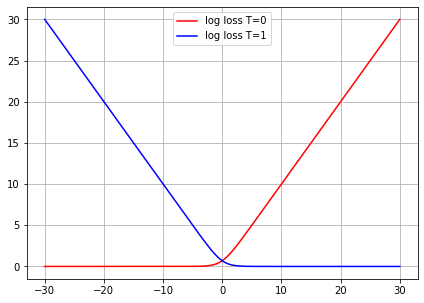

In [20]:
x = np.linspace(-30, 30, 1000)
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(x, __logistic_log_loss(x, 0), color='r', label="log loss T=0")
ax.plot(x, __logistic_log_loss(x, 1), color='b', label="log loss T=1")

ax.legend()
ax.grid(True)
#plt.show()

## Derivative of Logistic Log Loss

$L=log(1-Z)$ when ```T=0``` may looks to become $\infty$ as ```Z``` gets close to 1 where $log(0) \rightarrow \infty$. Then the gradient $\frac {\partial L(X)}{X} = Z$ can be counter-intuitive. How come the derivative can be $\approx 1 with X = \infty$. 

However, as in the diagram, the logistic log loss does not go to $\infty$ because ```sigmoid(X)``` is in the middle preventing ```(1 - Z)``` from becoming 0. Hence $L=Log(1-Z)$ does not get $\infty$.   

---

# Saturation

When gradient get closer to 0, the gradient descent / back propagation will not progress further.

## Sigmoid 

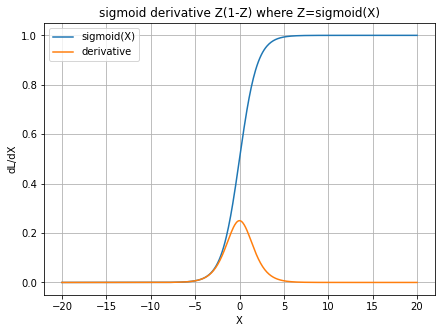

In [7]:
x = np.linspace(left,right,N)
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(x, __sigmoid(x), label="sigmoid(X)")
ax.plot(x, __sigmoid_gradient(x), label="derivative")

ax.set_xlabel("X")
ax.set_ylabel("dL/dX")
ax.set_title("sigmoid derivative Z(1-Z) where Z=sigmoid(X)")
ax.legend()
ax.grid(True)
#plt.show()

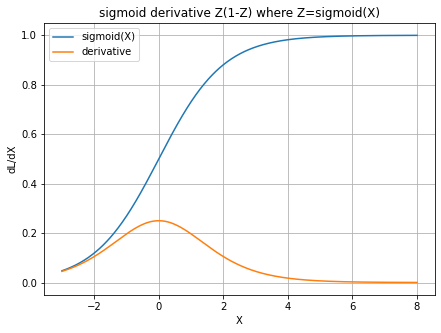

In [8]:
left = -3
right = 8
x = np.linspace(left,right,N)
z = __sigmoid(x)
#plt.plot(x, z)
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(x, __sigmoid(x), label="sigmoid(X)")
ax.plot(x, __sigmoid_gradient(x), label="derivative")

ax.set_xlabel("X")
ax.set_ylabel("dL/dX")
ax.set_title("sigmoid derivative Z(1-Z) where Z=sigmoid(X)")
ax.legend()
ax.grid(True)
#plt.show()

---

# Offsets to mitigate inf 

## log(x)

As ```x``` get closer to 0, the value $log(x) \rightarrow -inf$ and its gradient $\frac {\partial log(x)}{\partial x} \rightarrow inf$. The domain of ```x``` needs to be carefully considered to avoid ```inf```.

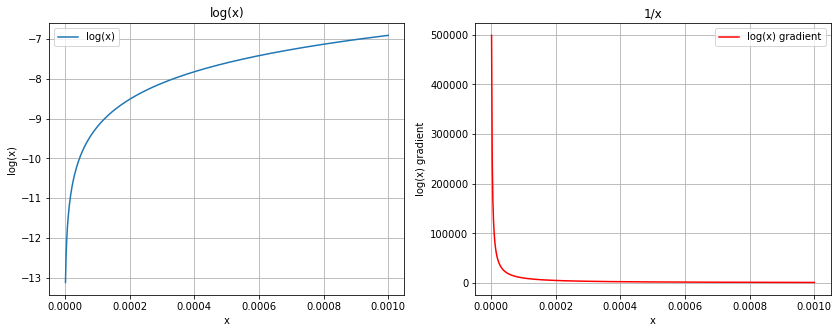

In [9]:
h = 1e-3
x = np.linspace(0,h,N)[1::]    # Excluding 0 to avoid log(0)
fig, ax = plt.subplots(1,2, figsize=(14,5)) 
ax[0].plot(x, np.log(x), label='log(x)')  
ax[0].set_xlabel('x')  # Add an x-label to the axes.
ax[0].set_ylabel('log(x)')  # Add a y-label to the axes.
ax[0].set_title("log(x)")  # Add a title to the axes.
ax[0].grid()
ax[0].legend()  # Add a legend.

ax[1].plot(x, 1/x, label='log(x) gradient', color='r')  
ax[1].set_xlabel('x')  # Add an x-label to the axes.
ax[1].set_ylabel('log(x) gradient')  # Add a y-label to the axes.
ax[1].set_title("1/x")  # Add a title to the axes.
ax[1].grid()
ax[1].legend()  # Add a legend.

## k for log(+k)

Adding a small value ```k``` log(x+k) to avoid log(0)->np.inf by log(0+k) causes clipping effect. For ```k=1e-6```, values of ```np.log(x+k)``` are clipped by ```np.log(k) = -13.815510557964274```. This effects on related functions using log.


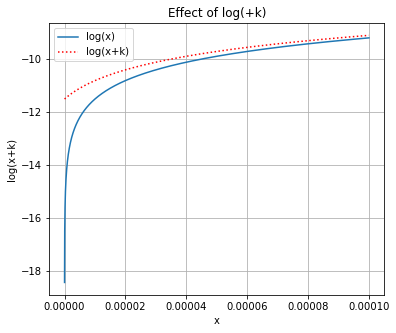

In [10]:
k = 1e-5
x = np.linspace(0,0.0001,10000)[1::]    # Excluding 0 to avoid log(0)
y = np.log(x+k)[1:-1:10]
fig, ax = plt.subplots(figsize=(6,5)) 
ax.plot(x, np.log(x), label='log(x)')  
ax.plot(
    x[0:-1:5], np.log(x+k)[0:-1:5], label='log(x+k)', 
    color='red', linestyle='dotted'
)
ax.set_xlabel('x')  # Add an x-label to the axes.
ax.set_ylabel('log(x+k)')  # Add a y-label to the axes.
ax.set_title("Effect of log(+k)")  # Add a title to the axes.
ax.grid()
ax.legend()  # Add a legend.

When ```x``` gets closer to 0, the effect of ```log(+k)``` cannot be negligible because $\frac {\partial log(x+k-h)}{\partial h} >> \frac {\partial log(x-h)}{\partial h}$. Hence need to be careful with the range of ```x``` in relation to ```k``` for the numerical gradient ```gn``` to be relatively close to the analytical gradient ```g``` with the delta ```h``` in the calculation $\frac {f(x+h) - f(x-h)}{2h}$.

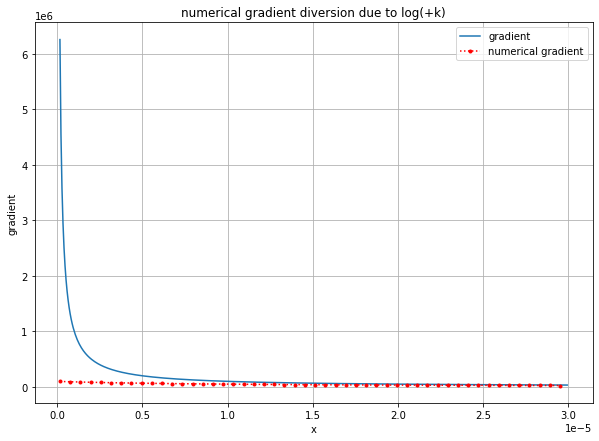

In [11]:
h = 1e-7
k = 1e-05
assert h < k
x = np.linspace(h,3e-05,500)[1:-1]

def log_gn(X, k, h):
    """Numerical gradient for logistic log loss"""
    return [
        __numerical_jacobian(lambda x: np.log(x+k), x, delta=h)
        for x in X 
    ]


fig, ax = plt.subplots(figsize=(10,7)) 
ax.plot(x, 1/x, label='gradient')  
ax.plot(
    x[0:-1:10], 
    log_gn(x, k, h)[0:-1:10], 
    color="red", linestyle='dotted', marker='o', markersize=3,
    label='numerical gradient'
)
ax.set_xlabel('x')  # Add an x-label to the axes.
ax.set_ylabel('gradient')  # Add a y-label to the axes.
ax.set_title("numerical gradient diversion due to log(+k)")
ax.grid()
ax.legend()  # Add a legend.

---

# Impact by log(k) on logistic log loss

For ```T == 1```, the logistic log loss is clipped by ```-np.log(k)``` as its max value.

$
L = -\left[\;
    Tlog(P) - (1-T)log(1-P)
\; \right]
$


## Logistic log loss values and analytical gradient without log(k) 

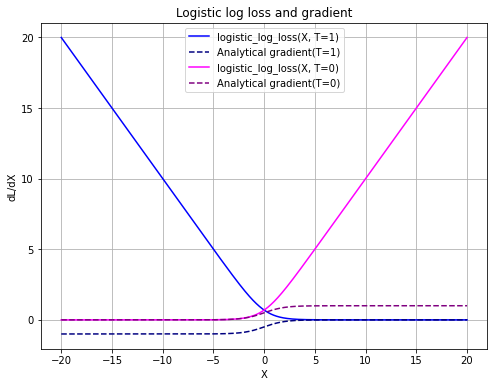

In [12]:
N = 1000
left=-20
right=20

X = np.linspace(left,right,N)
T0 = np.zeros(N)
T1 = np.ones(N)

# --------------------------------------------------------------------------------
# T = 1
# --------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(
    X,
    __logistic_log_loss(X, T1),
    color='blue', linestyle='solid',
    label="logistic_log_loss(X, T=1)"
)
ax.plot(
    X, 
    __logistic_log_loss_gradient(X, T1),
    color='navy', linestyle='dashed',
    label="Analytical gradient(T=1)"
)

# --------------------------------------------------------------------------------
# T = 0
# --------------------------------------------------------------------------------
ax.plot(
    X, 
    __logistic_log_loss(X, T0), 
    color='magenta', linestyle='solid',
    label="logistic_log_loss(X, T=0)"
)
ax.plot(
    X, 
    __logistic_log_loss_gradient(X, T0),
    color='purple', linestyle='dashed', 
    label="Analytical gradient(T=0)"
)

ax.set_xlabel("X")
ax.set_ylabel("dL/dX")
ax.set_title("Logistic log loss and gradient")
ax.legend()
ax.grid(True)
#plt.show()

## Numeric gradient deviation from analytical gradient due to log(k)

When adding k as in log(+k), the logistic log loss value is clipped. Hence, its derivative satulates and starts diverging from the analytical gradient when the X value gets closer to ```abs(X) = 13.815510557964274``` and becomes ```0```. However, the true gradient is ```1``` as $\frac {\partial log(z)}{\partial x} = (Z-T) = 1$ where $T = 1 \; Z = sigmoid(x))$

Expected clipped value of logisctic log loss {-log(sigmoid(-20)+k)} is [11.512719370847263].


<Figure size 1440x1080 with 0 Axes>

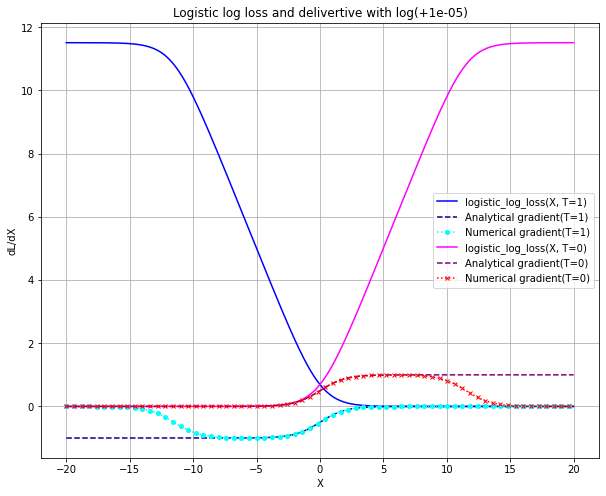

In [28]:
N = 1000
left=-20
right=20
k = 1e-5

print("Expected clipped value of logisctic log loss {} is [{}].".format(
    "{-log(sigmoid(-20)+k)}", -np.log(__sigmoid(-20)+k)
))

X = np.linspace(left,right,N)
T0 = np.zeros(N)
T1 = np.ones(N)

plt.figure(figsize=(20,15))
# --------------------------------------------------------------------------------
# T = 1
# --------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(
    X,
    __logistic_log_loss(X, T1, offset=k),
    color='blue', linestyle='solid',
    label="logistic_log_loss(X, T=1)"
)
ax.plot(
    X, 
    __logistic_log_loss_gradient(X, T1),
    color='navy', linestyle='dashed',
    label="Analytical gradient(T=1)"
)

ax.plot(
    X[0:-1:15], 
    __gn(X, 1, k)[0:-1:15],
    color='cyan', linestyle='dotted', marker='o', markersize=4,
    label="Numerical gradient(T=1)"
)
# --------------------------------------------------------------------------------
# T = 0
# --------------------------------------------------------------------------------
ax.plot(
    X, 
    __logistic_log_loss(X, T0, offset=k), 
    color='magenta', linestyle='solid',
    label="logistic_log_loss(X, T=0)"
)
ax.plot(
    X, 
    __logistic_log_loss_gradient(X, T0),
    color='purple', linestyle='dashed', 
    label="Analytical gradient(T=0)"
)
ax.plot(
    X[0:-1:15],
    __gn(X, 0, k)[0:-1:15],
    color='red', linestyle='dotted', marker='x', markersize=4,
    label="Numerical gradient(T=0)"
)

ax.set_xlabel("X")
ax.set_ylabel("dL/dX")
ax.set_title(f"Logistic log loss and delivertive with log(+{k})")
ax.legend()
ax.grid(True)
#plt.show()

As $z = sigmoid(x)$ gets close to ```k=1e-5```

In [15]:
k = 1e-5
print(__sigmoid_reverse(k))    # x for k=sigmoid(x)
print(np.log(k))

-11.512915464920228
-11.512925464970229


<img src="image/log(+k)_effect_to_prevent_log(0)_inf.png" align="left"/>

# k decides the boundaries

The x values we can use in X as the input to the logistic log loss are constrainted by the ```k```. 

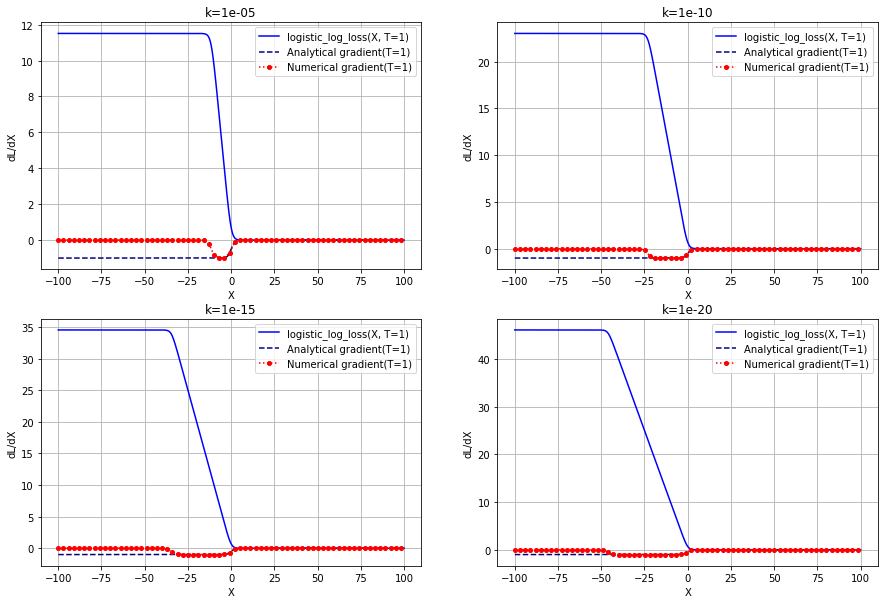

In [16]:
left=-100
right=100
K = [[1e-5, 1e-10],[1e-15, 1e-20]]
X = np.linspace(left,right,N)
T1 = np.ones(N)

fig, ax = plt.subplots(2,2, figsize=(15,10))
for r,c in product([0,1], repeat=2):
    L1 = lambda x: __logistic_log_loss(X=x, T=1, offset=K[r][c])
    GN1 = [__numerical_jacobian(L1, x) for x in X ]


    # --------------------------------------------------------------------------------
    # T = 1
    # --------------------------------------------------------------------------------

    ax[r][c].plot(
        X,
        __logistic_log_loss(X, T1, offset=K[r][c]),
        color='blue', linestyle='solid',
        label="logistic_log_loss(X, T=1)"
    )
    ax[r][c].plot(
        X, 
        __logistic_log_loss_gradient(X, T1),
        color='navy', linestyle='dashed',
        label="Analytical gradient(T=1)"
    )
    ax[r][c].plot(
        X[0:-1:15], 
        __gn(X, 1, K[r][c])[0:-1:15],
        color='red', linestyle='dotted', marker='o', markersize=4,
        label="Numerical gradient(T=1)"
    )

    ax[r][c].set_xlabel("X")
    ax[r][c].set_ylabel("dL/dX")
    ax[r][c].legend()
    ax[r][c].grid(True)
    ax[r][c].set_title(f"k={K[r][c]}")
#plt.show()

---

# Limitations and errors by limited float precision storage

The storage limit of the float number e.g 64 bit IEEE format sets the limits on the float calculations. While the required precision is relatively low, the errors (loss of accuracy, etc) can be relatively negligible. With higher precisions, the error causes unexpected result.

* [numpy - why numerical gradient log(1-sigmoid(x)) diverges but log(sigmoid(x)) does not?](https://stackoverflow.com/questions/66398361/numpy-why-numerical-gradient-log1-sigmoidx-diverges-but-logsigmoidx-do)

* [Approach to address errors from float precision limits by its storage limit](https://math.stackexchange.com/questions/4042781/approach-to-address-errors-from-float-precision-limits-by-its-storage-limit)

## Errors by precision limits

The numerical gradient $(f(x+h)-f(x-h))/2h$ can get unreliable due to the errors form the precision limits. The accumulated errors via multiple operations with high precisions cannot be negligible and causes the error.

In the example, $L = 1-sigmoid(X)$

In [17]:
def t_0_loss(X):
    return [
        #logistic_log_loss(P=sigmoid(x), T=0)
        -np.log(1.0 - __sigmoid(x)) for x in X 
    ]

def t_1_loss(X):
    return [
        #logistic_log_loss(P=sigmoid(x), T=1)
        -np.log(__sigmoid(x)) for x in X 
    ]


def gn_plot(X, k):
    fig, axes = plt.subplots(1, 2, figsize=(12,8))

    # --------------------------------------------------------------------------------
    # T = 0
    # --------------------------------------------------------------------------------
    axes[0].plot(
        X,
        ((np.array(t_0_loss(X + k)) - np.array(t_0_loss(X - k))) / (2*k)),
        color='red', linestyle='solid',
        label="Diffed numerical gradient(T=0)"
    )
    axes[0].plot(
        X[0:-1:20],
        ((np.array(t_0_loss(X + k)) - np.array(t_0_loss(X))) / k)[0:-1:20],
        color='black', linestyle='dotted', marker='x', markersize=4,
        label="Left numerical gradient(T=0)"
    )
    axes[0].plot(
        X[0:-1:20],
        ((np.array(t_0_loss(X)) - np.array(t_0_loss(X - k))) / k)[0:-1:20],
        color='salmon', linestyle='dotted', marker='o', markersize=5,
        label="Right numerical gradient(T=0)"
    )

    axes[0].set_xlabel("X")
    axes[0].set_ylabel("dL/dX")
    axes[0].set_title(f"T=0: -log(1-sigmoid(x)) k={k}")
    axes[0].legend()
    axes[0].grid(True)

    # --------------------------------------------------------------------------------
    # T = 1
    # --------------------------------------------------------------------------------
    axes[1].plot(
        X,
        ((np.array(t_1_loss(X + k)) - np.array(t_1_loss(X - k))) / (2*k)),
        color='blue', linestyle='solid',
        label="Diffed numerical gradient(T=1)"
    )
    axes[1].plot(
        X[0:-1:20],
        ((np.array(t_1_loss(X + k)) - np.array(t_1_loss(X))) / k)[0:-1:20],
        color='cyan', linestyle='dashed', marker='x', markersize=5,
        label="Left numerical gradient(T=1)"
    )
    axes[1].plot(
        X[0:-1:20],
        ((np.array(t_1_loss(X)) - np.array(t_1_loss(X - k))) / k)[0:-1:20],
        color='yellow', linestyle='dotted', marker='o', markersize=5,
        label="Right numerical gradient(T=1)"
    )

    axes[1].set_xlabel("X")
    axes[1].set_ylabel("dL/dX")
    axes[1].set_title(f"T=1: -log(sigmoid(x) k={k}")
    axes[1].legend()
    axes[1].grid(True)


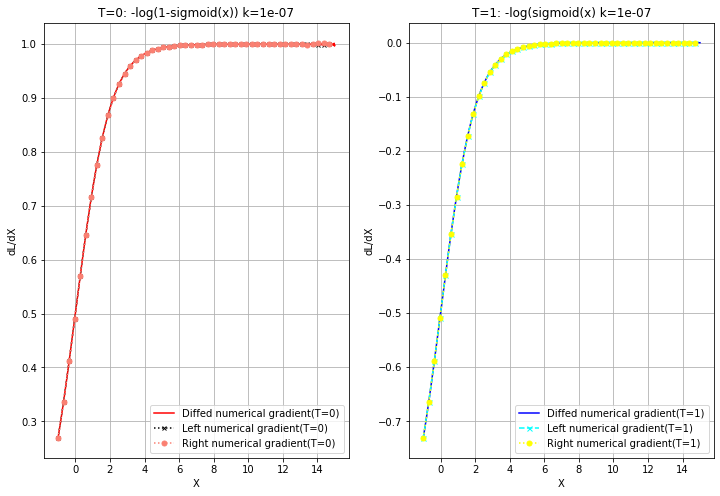

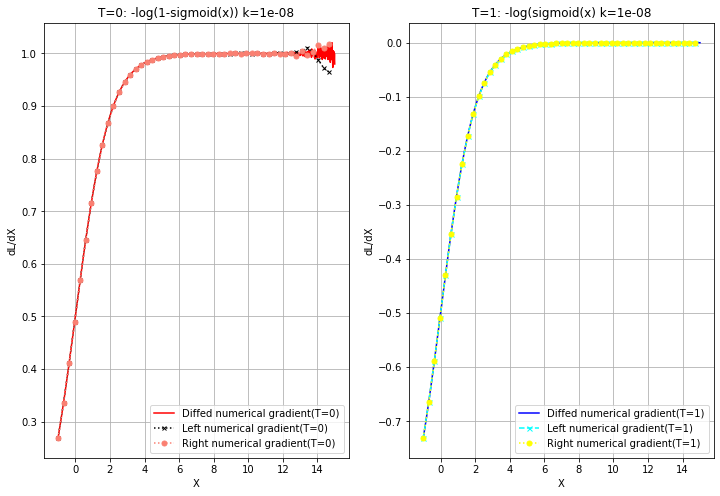

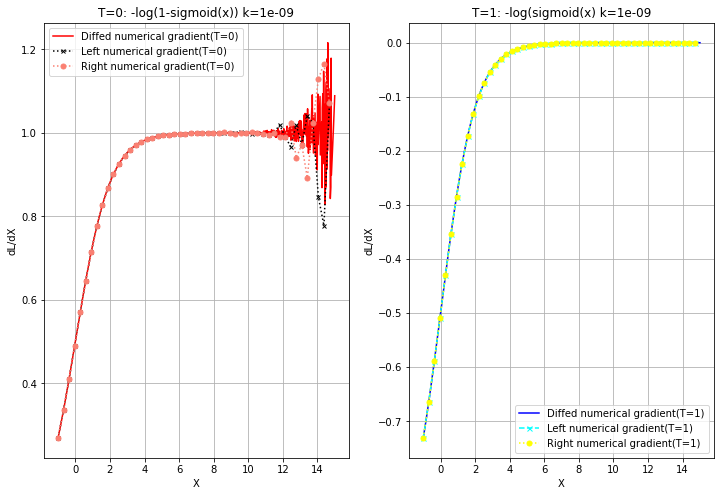

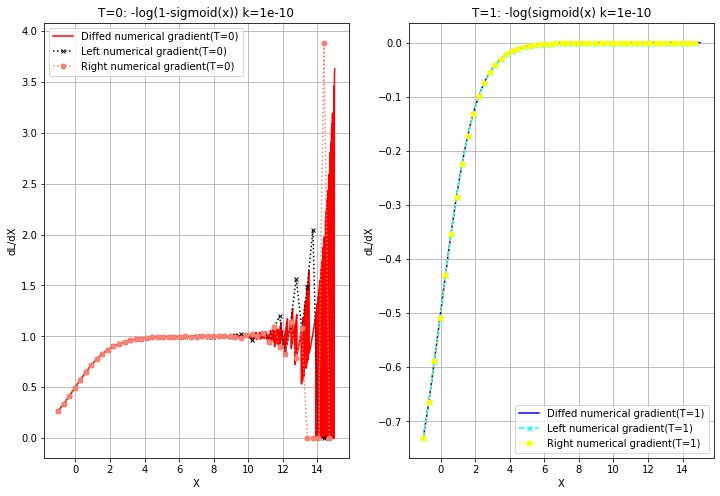

In [18]:
N = 1000
left=-1
right=15

# Numerical gradient
# (f(x+k)-f(x-k)) / 2h 

K = [1e-7, 1e-8, 1e-9, 1e-10]
X = np.linspace(left,right,N)

for k in K:
    gn_plot(X, k)

---

# Note

## Sigmoid and log
k and sigmoid(np.log(k)) looks similar when k << 0 but it is not.

In [20]:
k = [1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10]
for _ in k:
    print("{:.100f}".format(_ - __sigmoid(np.log(_))))

0.0000000000999990000117564675416459429868609731784090399742126464843750000000000000000000000000000000
0.0000000000009999989994699347555656698816051175526808947324752807617187500000000000000000000000000000
0.0000000000000099999990568930919926024514232665296731283888220787048339843750000000000000000000000000
0.0000000000000001000000165754893785932146121897545754109160043299198150634765625000000000000000000000
0.0000000000000000009999993220306689818439177530606798427470494061708450317382812500000000000000000000
0.0000000000000000000100000449190949743826688569936500528001488419249653816223144531250000000000000000


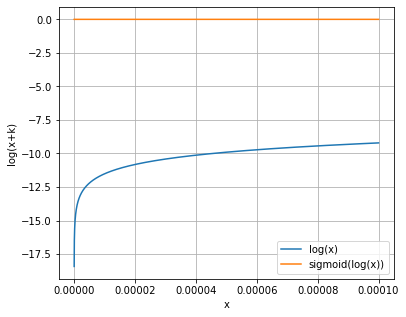

In [21]:
k = 1e-5
x = np.linspace(0,0.0001,10000)[1::]    # Excluding 0 to avoid log(0)
fig, ax = plt.subplots(figsize=(6,5)) 
ax.plot(x, np.log(x), label='log(x)')  
ax.plot(x, __sigmoid(np.log(x)), label="sigmoid(log(x))")

ax.set_xlabel('x')  # Add an x-label to the axes.
ax.set_ylabel('log(x+k)')  # Add a y-label to the axes.
ax.grid()
ax.legend()  # Add a legend.

In [26]:
__sigmoid(12.5)

0.9999962733607158